In [30]:
import os
import tweepy as tw
import pandas as pd
import yaml

import re
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

Using this site as reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

# Step 1: Set up Twitter API access
Set up the project here: https://developer.twitter.com/en/portal/projects-and-apps

In [31]:
# Reference: https://gist.github.com/radcliff/47af9f6238c95f6ae239
# Load yml file to dictionary
credentials = yaml.load(open('./credentials.yml'), Loader=yaml.FullLoader)

# Define access keys and tokens
consumer_key = credentials['twitter_api']['consumer_key']
consumer_secret = credentials['twitter_api']['consumer_secret']
access_token = credentials['twitter_api']['access_token']
access_token_secret = credentials['twitter_api']['access_token_secret']

In [32]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit = True)

# Step 2: Get tweets and transform into dataframe

In [33]:
# Reference: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/twitter-data-in-python/

# define parameters for API request
search_word = "#covidcanada"
num_of_tweets = 1000
include_retweets = False
language = "en"

if include_retweets == False:
    search_word = search_word + " -filter:retweets"

tweets = tw.Cursor(api.search,
                    q=search_word,
                    lang=language).items(num_of_tweets)

In [34]:
# Twitter API data dictionary: https://developer.twitter.com/en/docs/twitter-api/data-dictionary/object-model/tweet

# Get column names
api_colnames_call = api.search(q=search_word, count=num_of_tweets)
json_data = [c._json for c in api_colnames_call]

# create dataframe from JSON result
api_colnames = pd.json_normalize(json_data)

# print all column names
for col in api_colnames.columns:
    print(col)

created_at
id
id_str
text
truncated
source
in_reply_to_status_id
in_reply_to_status_id_str
in_reply_to_user_id
in_reply_to_user_id_str
in_reply_to_screen_name
geo
coordinates
place
contributors
is_quote_status
retweet_count
favorite_count
favorited
retweeted
possibly_sensitive
lang
entities.hashtags
entities.symbols
entities.user_mentions
entities.urls
metadata.iso_language_code
metadata.result_type
user.id
user.id_str
user.name
user.screen_name
user.location
user.description
user.url
user.entities.url.urls
user.entities.description.urls
user.protected
user.followers_count
user.friends_count
user.listed_count
user.created_at
user.favourites_count
user.utc_offset
user.time_zone
user.geo_enabled
user.verified
user.statuses_count
user.lang
user.contributors_enabled
user.is_translator
user.is_translation_enabled
user.profile_background_color
user.profile_background_image_url
user.profile_background_image_url_https
user.profile_background_tile
user.profile_image_url
user.profile_image_url_h

In [35]:
# pecify which columns to pull from API
tweet_metadata = [[tweet.created_at, tweet.id, tweet.text, tweet.user.screen_name, tweet.retweet_count, tweet.favorite_count] for tweet in tweets]

print(tweet_metadata[:2])

[[datetime.datetime(2021, 5, 30, 18, 43, 29), 1399073998407815168, 'Canadian study looking to prevent COVID-19 infections https://t.co/RNC5Q9QjHB #COVID19 #COVID_19 #COVIDCanada #COVID19Canada', 'iChinadian', 0, 0], [datetime.datetime(2021, 5, 30, 17, 4, 5), 1399048982073073664, 'Daily data update as of 12:57pm 30-05-2021 #COVID #COVID19 #COVIDData #COVIDVaccine #COVID19Vaccine #COVIDCanada… https://t.co/at9kSfKqKO', 'canadacovidvac', 1, 0]]


In [36]:
df_tweets_raw = pd.DataFrame(data=tweet_metadata, columns=['created_at', 'id', 'text', 'user', 'rt_count', 'fav_count'])
df_tweets_raw.head()

,created_at,id,text,user,rt_count,fav_count
0,2021-05-30 18:43:29,1399073998407815168,Canadian study looking to prevent COVID-19 inf...,iChinadian,0,0
1,2021-05-30 17:04:05,1399048982073073664,Daily data update as of 12:57pm 30-05-2021 #CO...,canadacovidvac,1,0
2,2021-05-30 16:20:57,1399038127877115906,Meet a few of the people working hard daily to...,torontodotcom,1,0
3,2021-05-30 15:43:32,1399028714948734976,"Ontario is reporting 1,033 new cases of COVID-...",torontodotcom,0,1
4,2021-05-30 15:21:39,1399023206820761602,"Ontario reports just over 1,000 new COVID-19 c...",iChinadian,0,0


# Step 3: Exploratory data analysis (EDA)

In [37]:
print('Rows:', df_tweets_raw.shape[0], '\nColumns:', df_tweets_raw.shape[1])

Rows: 196 
Columns: 6


In [38]:
max_tweet_length = df_tweets_raw.text.apply(len).max()
print('Longest tweet is', max_tweet_length, 'characters long')

Longest tweet is 144 characters long


In [39]:
min_date = df_tweets_raw.created_at.min()
max_date = df_tweets_raw.created_at.max()

print('Min. date: ', min_date, '\nMax. date: ', max_date)

Min. date:  2021-05-23 10:26:23 
Max. date:  2021-05-30 18:43:29


In [40]:
df_tweets_raw.describe(include='all')

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,created_at,id,text,user,rt_count,fav_count
count,196,1.960000e+02,196,196,196.000000,196.000000
unique,195,NaN,196,59,NaN,NaN
top,2021-05-27 18:20:04,NaN,"Ontario reports just over 1,000 new COVID-19 c...",iChinadian,NaN,NaN
freq,2,NaN,1,66,NaN,NaN
first,2021-05-23 10:26:23,NaN,NaN,NaN,NaN,NaN
last,2021-05-30 18:43:29,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.397754e+18,NaN,NaN,0.392857,1.545918
std,NaN,7.203518e+14,NaN,NaN,1.024695,5.598803
min,NaN,1.396412e+18,NaN,NaN,0.000000,0.000000
25%,NaN,1.397235e+18,NaN,NaN,0.000000,0.000000


# Step 4: Clean data

In [17]:
df_tweets = df_tweets_raw.copy()

In [18]:
df_tweets_raw.text[26]

'Event Today! \n\nWhich tools and techniques can we add to our toolbox in an effort to manage the current COVID-19 inf… https://t.co/mALGt8HoFO'

In [19]:
# sample tweets
for i in range(0,5):
    print(str(i+1) + ') ' + df_tweets_raw.text[i] + '\n')

1) B.C. shortens interval between COVID-19 vaccine doses to eight weeks https://t.co/jbemYnJTeV #COVIDBC #COVIDCanada… https://t.co/Hp84gYaeCv

2) @OmarAlghabra, @CanadianPM, @JustinTrudeau is the government going to follow the advice of its advisory panel and e… https://t.co/6g7iyzz3uP

3) COVID-19 in B.C.: Dose interval shortened; non-urgent surgeries resume; UBC rapid-testing clinic; and more 
#BC… https://t.co/NoYvVWqDRA

4) Daily COVID-19 cases tick up, seven more deaths https://t.co/8P5OWW1cDn via @viawesome #COVIDBC #COVIDCanada #COVID19BC #COVID19Canada

5) Well, at least I didn't have to pay duty and GST on my imported Covid vaccine.

#COVIDCanada #AbCOVID19 #COVID19AB… https://t.co/EsTPfGXUqV



## Step 4a: Convert tweets to lower case

In [20]:
# Convert transcripts to lower case
df_tweets['text_cleaned'] = df_tweets['text'].map(lambda x: x.lower())

In [21]:
df_tweets.text_cleaned[26]

'event today! \n\nwhich tools and techniques can we add to our toolbox in an effort to manage the current covid-19 inf… https://t.co/malgt8hofo'

## Step 4b: Remove custom stop words

In [90]:
# Remove punctuation, new line symbol (\n), boilerplate text (eg. customer name, Blue Shirt Chatter name, timestamps)
# df_tweets['text_cleaned'] = df_tweets['text_cleaned'].map(lambda x: re.sub('([,\.:!?])|(.*?\((.*?):)|\n', '', x))

# Remove tweet URLs
df_tweets['text_cleaned'] = df_tweets['text_cleaned'].map(lambda x: re.sub(r'https\:\/\/t\.co\/*\w*', '', x, flags=re.MULTILINE).strip())

# Print out sample of cleaned transcripts
print("Cleaned tweet:\n" + df_tweets['text_cleaned'][26])

Cleaned tweet:
#canada extends mandatory hotel quarantine travel policy until late june  #covidcanada


In [89]:
sample_text = '#canada extends mandatory hotel quarantine travel policy until late june https://t.co/gfo1xzswv1 #covidcanada https://t.co/b9zb3yd0iz'
cleaned_text = re.sub(r'https\:\/\/t\.co\/*\w*', '', sample_text).strip()
print(cleaned_text)

#canada extends mandatory hotel quarantine travel policy until late june  #covidcanada


# Step 5: Analyze tweets

## Step 5a: n-grams

In [55]:
sns.set_style('whitegrid')
%matplotlib inline

C:\Users\S Lo\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


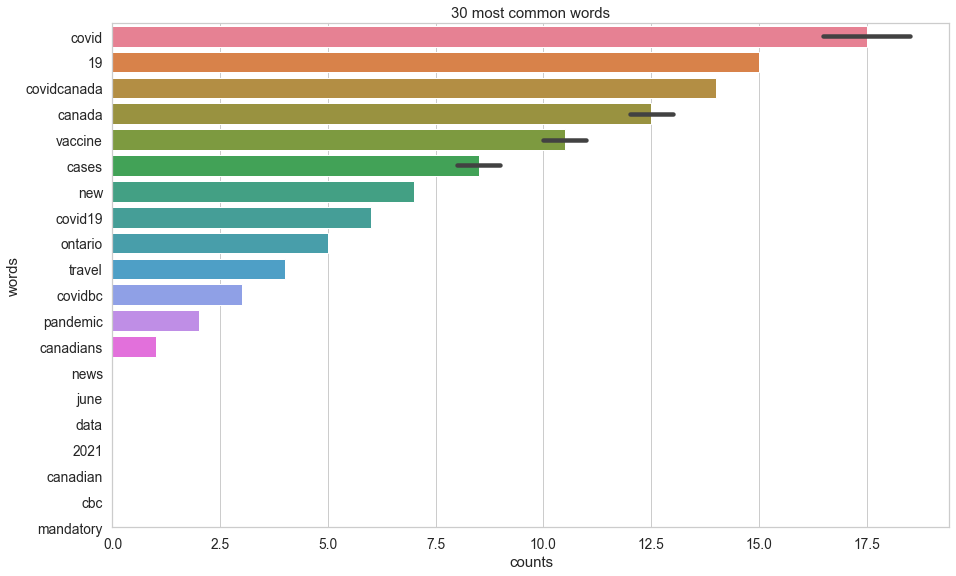

In [91]:
# Helper function
def plot_30_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:20]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='30 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl', orient = 'h')
    plt.yticks(x_pos, words) 
    plt.ylabel('words')
    plt.xlabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed transcripts
count_data = count_vectorizer.fit_transform(df_tweets['text_cleaned'])

# Visualise the 30 most common words
plot_30_most_common_words(count_data, count_vectorizer)

Travel, news / new info, vaccines

## Step 5b: Sentiment analysis

In [5]:
#TODO: Dom to troubleshoot - why tweets are the same
# initialize list
new_df = []

for tweet in df_tweets['text_cleaned']:
    blob = TextBlob(str(tweet))
    score = {
        'text': df_tweets['text'],
        'polarity': blob.sentiment.polarity,
        'subjectivity': blob.sentiment.subjectivity
    }
    new_df.append(score)
    #print(score)

# turn the new_df 
test = pd.DataFrame(new_df)

# remove rows where polarity = 0.000
test = test[(test.polarity != 0.0000)]
print(test.head())

test.to_csv('data/sentiment_reviews.csv', index=False)

NameError: name 'df_tweets' is not defined